# Unsupervised Learning: Dimensionality Reduction, Feature Extraction, Manifold Learning

In [1]:
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import warnings

from IPython.display import display
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

## Overview

이번장에서는 3가지 주제를 다룹니다.

    1. Principal Component Analysis (PCA)
    2. Non-Negative Matrix Factorization (NMF)
    3. Manifold Learning with t-SNE

## Principal Component Analysis (PCA)

    Principal component analysis is a method that rotates the dataset in a way such that the rotated features are statistically uncorrelated. 
    
PCA는 original data 에서 variance 를 가장 많이 주는 component 를 찾는 것입니다. (주의: component != feature)

아래 그림을 보시면 variance 를 많이 주는 component를 주는게 무슨 얘기인지 이해가 되실껍니다.

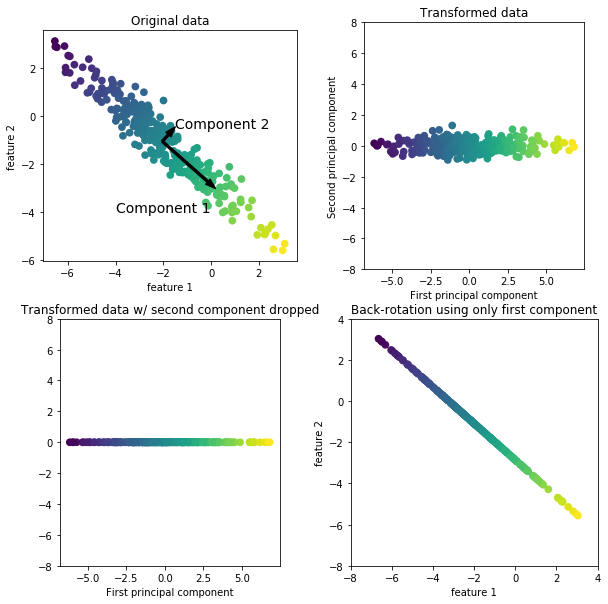

In [2]:
mglearn.plots.plot_pca_illustration()

PCA를 `cancer` 데이터에 돌려보겠습니다.

In [3]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(cancer.data)
X_scaled = scaler.transform(cancer.data)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, cancer.target, random_state=0)

In [4]:
from sklearn.decomposition import PCA
# keep the first two principal components of the data
pca = PCA(n_components=2)
# fit PCA model to breast cancer data
pca.fit(X_train)
# transform data onto the first two principal components
X_pca_train = pca.transform(X_train)
print("Original shape: {}".format(str(X_train.shape)))
print("Reduced shape: {}".format(str(X_pca_train.shape)))

Original shape: (426, 30)
Reduced shape: (426, 2)


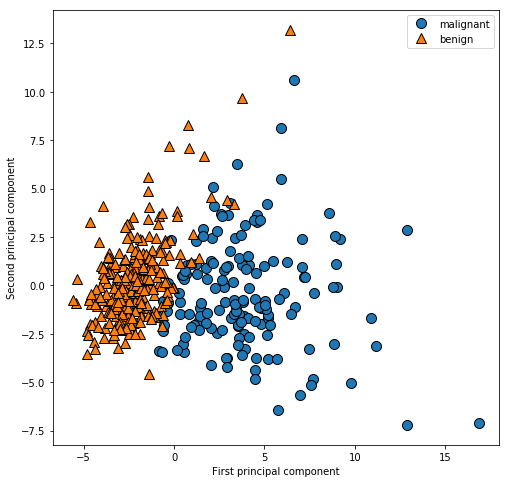

In [5]:
# plot first vs. second principal component, colored by class
plt.figure(figsize=(8, 8))
mglearn.discrete_scatter(X_pca_train[:, 0], X_pca_train[:, 1], y_train)
plt.legend(cancer.target_names, loc="best")
# plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component");

네, PCA를 사용해서 2개의 principal compoment 만 찾았더니 target에 따라 데이터가 확 나뉘네요.

그런데 말입니다. 여기서 **component != feature** 입니다. 따라서, 위 그래프를 봐도 x, y축이 뭘 나타내는지 잘 알 방법이 없다는거죠. 굳이 그려보자면 아래처럼됩니다.

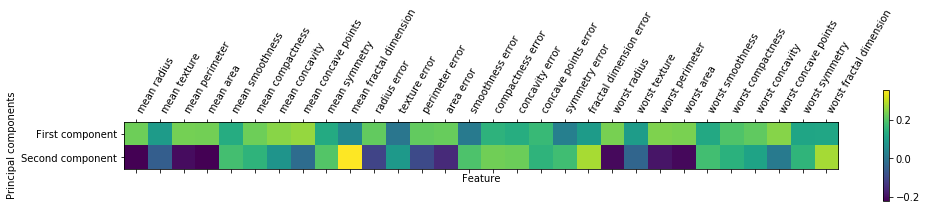

In [6]:
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(cancer.feature_names)),
           cancer.feature_names, rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components");

또 궁금한게요. PCA를 사용하면 prediction 이 더 좋아지는지 볼까요?

In [7]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)
print("Accuracy on scaled training set: {:.2f}".format(svc.score(X_train, y_train)))
print("Accuracy on scaled test set: {:.2f}".format(svc.score(X_test, y_test)))

Accuracy on scaled training set: 0.99
Accuracy on scaled test set: 0.97


In [8]:
svc = SVC()
svc.fit(X_pca_train, y_train)
X_pca_test = pca.transform(X_test)
print("Accuracy on PCA'ed training set: {:.2f}".format(svc.score(X_pca_train, y_train)))
print("Accuracy on PCA'ed test set: {:.2f}".format(svc.score(X_pca_test, y_test)))

Accuracy on PCA'ed training set: 0.96
Accuracy on PCA'ed test set: 0.92


네, `cancer`는 이미 scaling 만으로 겁나 잘되서, PCA한다고 더 잘되지 않네요. 책에서 같은 데이터셋으로 prediction 하지 않는 이유가 있었네요.

책에서는 `lfw` 얼굴데이터셋으로 PCA를 적용한 후 prediction score를 비교해봅니다. 별로 재밌는 내용이라고 생각지 않아, 여기서는 생략합니다.

## Non-Negative Matrix Factorization (NMF)

NMF는 dimensionality reduction, feature extraction 에 쓰이는 알고리즘입니다. 

PCA 와 다른점은요:

- Variance 에 따라 나누지 않고, matrix decomposition 으로 나눕니다 (decomposition 은 random 으로 시작하구요)
- non-negative 이름에서처럼 feature 들이 전부 non-negative 여야합니다. (image dataset은 잘 되겠죠. 픽셀들이 양수이니)
- NMF 는 decomposition 이기에 나눠진 component들이 PCA보다는 이해가 잘된답니다.

우선 NMF를 설명하는 toy data 그림을 보시죠.

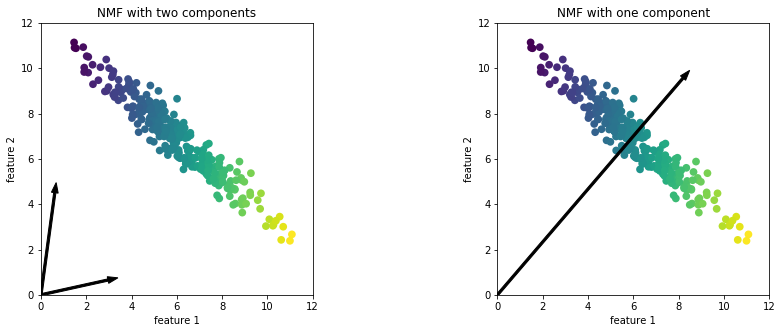

In [9]:
mglearn.plots.plot_nmf_illustration()

`lfw`데이터에 NMF를 적용해봅시다. 위에서 PCA를 적용하지 않았지만 (책에는 나옵니다), 그것보다 훨씬 더 그럴듯해보입니다.

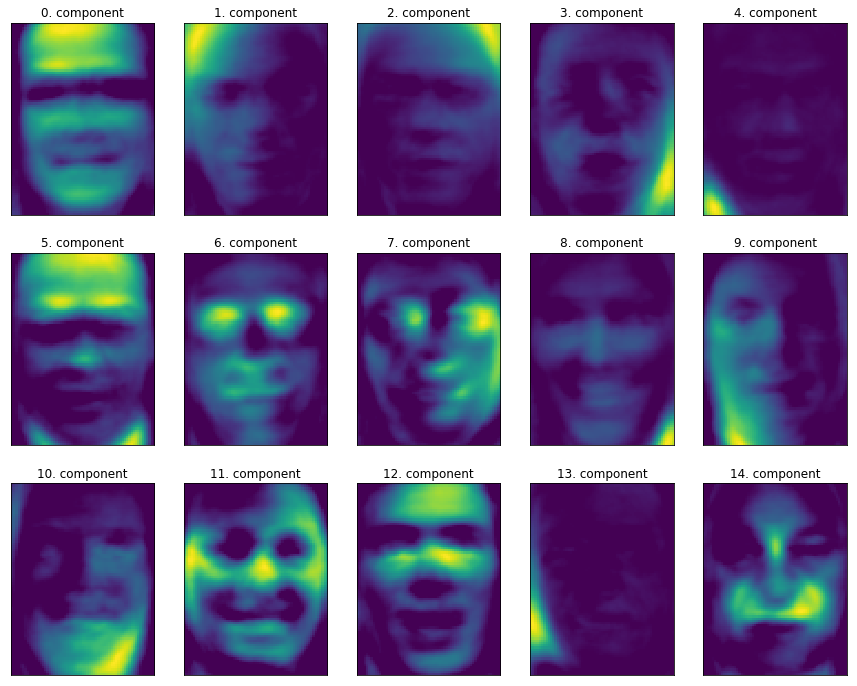

In [10]:
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)

mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1

X_people = people.data[mask]
y_people = people.target[mask]
# scale the grayscale values to be between 0 and 1
# instead of 0 and 255 for better numeric stability
X_people = X_people / 255.

from sklearn.neighbors import KNeighborsClassifier
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_people, y_people, stratify=y_people, random_state=0)

image_shape = (87, 65)

# mglearn.plots.plot_nmf_faces(X_train, X_test, image_shape)

from sklearn.decomposition import NMF
nmf = NMF(n_components=15, random_state=0)
nmf.fit(X_train)
X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)
fix, axes = plt.subplots(3, 5, figsize=(15, 12),
                         subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(nmf.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("{}. component".format(i));

이제 `make_signal()`에 적용해볼까요? 여기서, 이렇게 보시죠.
- `S`: 실제 original data
- `X`: 우리가 noise 받으면서 observe 한 데이터

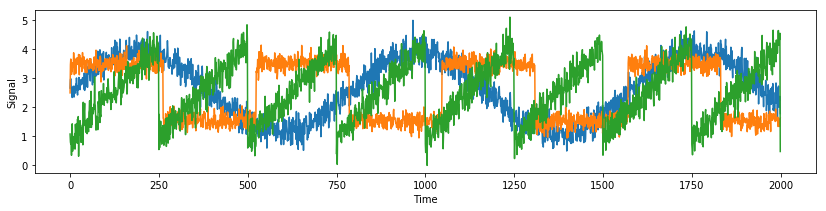

In [11]:
S = mglearn.datasets.make_signals()
plt.figure(figsize=(14, 3))
plt.plot(S, '-')
plt.xlabel("Time")
plt.ylabel("Signal");

In [12]:
# mix data into a 100-dimensional state
A = np.random.RandomState(0).uniform(size=(100, 3))
X = np.dot(S, A.T)
print("Shape of measurements: {}".format(X.shape))

nmf = NMF(n_components=3, random_state=42)
S_ = nmf.fit_transform(X)
print("Recovered signal shape: {}".format(S_.shape))

pca = PCA(n_components=3)
H = pca.fit_transform(X)

Shape of measurements: (2000, 100)
Recovered signal shape: (2000, 3)


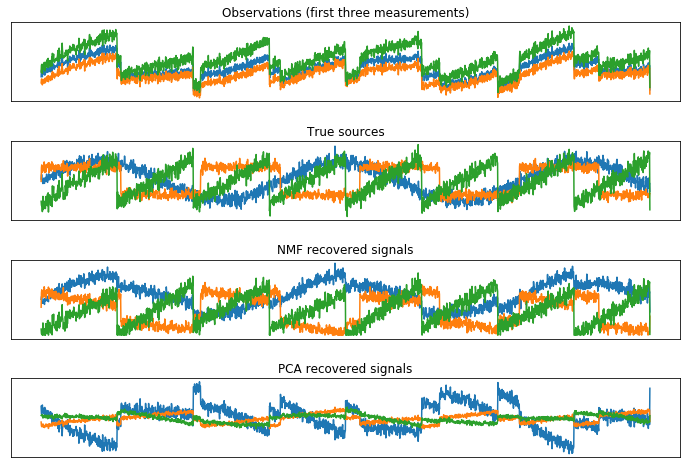

In [13]:
models = [X, S, S_, H]
names = ['Observations (first three measurements)',
         'True sources',
         'NMF recovered signals',
         'PCA recovered signals']
fig, axes = plt.subplots(4, figsize=(12, 8), gridspec_kw={'hspace': .5},
                         subplot_kw={'xticks': (), 'yticks': ()})
for model, name, ax in zip(models, names, axes):
    ax.set_title(name)
    ax.plot(model[:, :3], '-');

여기서는 `NMF`가 `PCA`보다 훨씬 더 그럴듯하게 잘 됩니다. 하지만, 그 둘을 자세히 설명하지는 않네요. 나중에 더 찾아봐야 할 듯합니다.

## Manifold Learning with t-SNE

`manifold learning`이라는건 완전 visualization 을 위한 알고리즘이라고 합니다. training 에서만 잘 동작하고, testing data는 무시하는거죠. training 에 대해서 완벽히 익혀서 데이터가 어떤식으로 있는지 보여준다네요.

유명한게 `t-SNE`인데요. random point에서 시작해서 가까이에 있는 있는것들은 더 가까이, 멀리 있는 것들은 더 멀리 떨어뜨린다네요.

예제를 볼까요?

In [14]:
from sklearn.datasets import load_digits
digits = load_digits()

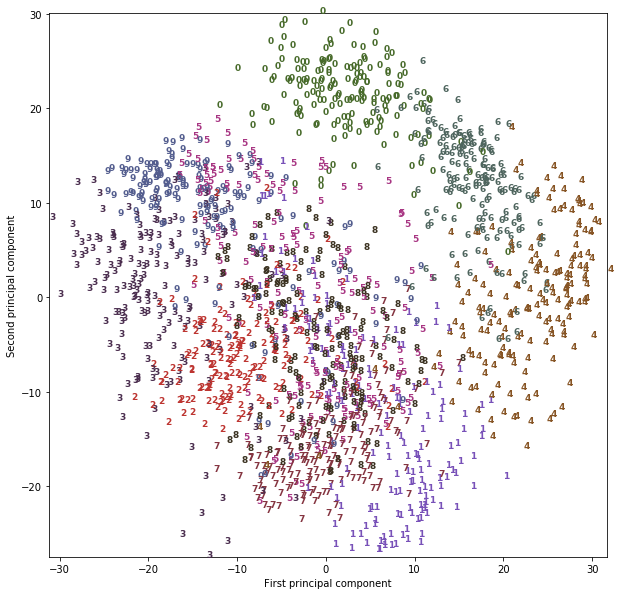

In [15]:
# build a PCA model
pca = PCA(n_components=2)
pca.fit(digits.data)
# transform the digits data onto the first two principal components
digits_pca = pca.transform(digits.data)
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]

plt.figure(figsize=(10, 10))
plt.xlim(digits_pca[:, 0].min(), digits_pca[:, 0].max())
plt.ylim(digits_pca[:, 1].min(), digits_pca[:, 1].max())
for i in range(len(digits.data)):
    # actually plot the digits as text instead of using scatter
    plt.text(digits_pca[i, 0], digits_pca[i, 1], str(digits.target[i]),
             color = colors[digits.target[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component");

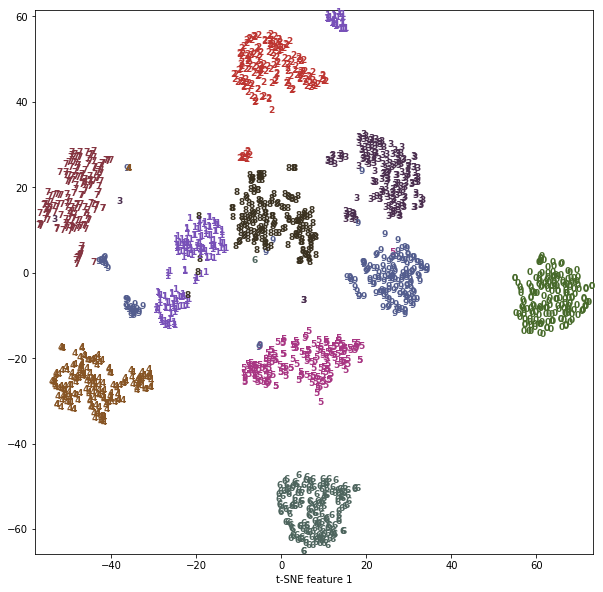

In [16]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=42)
# use fit_transform instead of fit, as TSNE has no transform method
digits_tsne = tsne.fit_transform(digits.data)
plt.figure(figsize=(10, 10))
plt.xlim(digits_tsne[:, 0].min(), digits_tsne[:, 0].max() + 1)
plt.ylim(digits_tsne[:, 1].min(), digits_tsne[:, 1].max() + 1)
for i in range(len(digits.data)):
    # actually plot the digits as text instead of using scatter
    plt.text(digits_tsne[i, 0], digits_tsne[i, 1], str(digits.target[i]),
             color = colors[digits.target[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("t-SNE feature 0")
plt.xlabel("t-SNE feature 1");

놀랍습니다. 특히나, label/target 데이터없이 그냥 clustering인데 결과가 아주 좋네요.

`t-SNE`는 `perplexity`, `early_exaggeration`등의 tuning parameter를 갖는다고 합니다.